# Importing Libraries

In [122]:
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")
import joblib

import pandas as pd
import numpy as np
import seaborn as sns
import missingno
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import zscore

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder,StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import lightgbm as lgb

from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_selection import SelectKBest,f_classif
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,roc_auc_score,f1_score,roc_curve,auc

#problem statement


Flight ticket prices can be something hard to guess, today we might see a price, check out the price of the same flight tomorrow, it will be a different story. We might have often heard travellers saying that flight ticket prices are so unpredictable. Here you will be provided with prices of flight tickets for various airlines between the months of March and June of 2019 and between various cities.

Size of training set: 10683 records

Size of test set: 2671 records

- FEATURES:

Airline: The name of the airline.

Date_of_Journey: The date of the journey

Source: The source from which the service begins.

Destination: The destination where the service ends.

Route: The route taken by the flight to reach the destination.

Dep_Time: The time when the journey starts from the source.

Arrival_Time: Time of arrival at the destination.

Duration: Total duration of the flight.

Total_Stops: Total stops between the source and destination.

Additional_Info: Additional information about the flight

Price: The price of the ticket

In [5]:
train = pd.read_excel('Data_Train.xlsx')
train.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In this train dataset depending upon several independent features we need to predict the Price of flight tickets.

The train dataset is having 11 columns out of which 10 columns are the feature data and 1 column is the label variable.

Now we can see this dataset is having mainly nominal data and categorical data and only the label data is a continuous one, that means it is a regression type of problem.

In [6]:
test = pd.read_excel('Test_set.xlsx')
test.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1 stop,No info
4,Air Asia,24/06/2019,Banglore,Delhi,BLR → DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info


This test dataset is having 10 independent features.

Like we have seen that test dataset is also having the same features except the dependent variable.

As the label column is missing, we will use this dataset after model training for testing purpose.

# EDA: Exploratory Data Analysis

In [13]:
print('checking the shape of train data')
print(train.shape)
print('\nchecking the shape of test data')
print(test.shape)

checking the shape of train data
(10683, 11)

checking the shape of test data
(2671, 10)


In [20]:
#let's check the datatype of both the datasets
print('\ndatatype of train dataset\n')
print(train.dtypes)

print('\ndatatype of test dataset\n')
print(test.dtypes)


datatype of train dataset

Airline            object
Date_of_Journey    object
Source             object
Destination        object
Route              object
Dep_Time           object
Arrival_Time       object
Duration           object
Total_Stops        object
Additional_Info    object
Price               int64
dtype: object

datatype of test dataset

Airline            object
Date_of_Journey    object
Source             object
Destination        object
Route              object
Dep_Time           object
Arrival_Time       object
Duration           object
Total_Stops        object
Additional_Info    object
dtype: object


all the columns are having categorical or nominal data except the target value, price is numerical

In [21]:
train.nunique()

Airline              12
Date_of_Journey      44
Source                5
Destination           6
Route               128
Dep_Time            222
Arrival_Time       1343
Duration            368
Total_Stops           5
Additional_Info      10
Price              1870
dtype: int64

we have 10000+ rows and the total unique price are 1870, so flight price are following some price pattern.

We have total 12 airlines

we got 6 city as destination and 5 source, which uneven.

In [22]:
test.nunique()

Airline             11
Date_of_Journey     44
Source               5
Destination          6
Route              100
Dep_Time           199
Arrival_Time       704
Duration           320
Total_Stops          5
Additional_Info      6
dtype: int64

here, we can't make any justification, everything will be clear on visualization

In [23]:
# getting info
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


there are two missing value present

In [24]:
test.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2671 entries, 0 to 2670
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          2671 non-null   object
 1   Date_of_Journey  2671 non-null   object
 2   Source           2671 non-null   object
 3   Destination      2671 non-null   object
 4   Route            2671 non-null   object
 5   Dep_Time         2671 non-null   object
 6   Arrival_Time     2671 non-null   object
 7   Duration         2671 non-null   object
 8   Total_Stops      2671 non-null   object
 9   Additional_Info  2671 non-null   object
dtypes: object(10)
memory usage: 208.8+ KB


no missing values


In [25]:
train.dropna(inplace=True)

dropping those two data as it does not make much difference for this big dataset

In [28]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,10682.0,9087.214567,4611.54881,1759.0,5277.0,8372.0,12373.0,79512.0


The difference of quartile 3 and maximum value is big. So, right skewness might be there.

In [34]:
test.describe().T

,count,unique,top,freq
Airline,2671,11,Jet Airways,897
Date_of_Journey,2671,44,9/05/2019,144
Source,2671,5,Delhi,1145
Destination,2671,6,Cochin,1145
Route,2671,100,DEL → BOM → COK,624
Dep_Time,2671,199,10:00,62
Arrival_Time,2671,704,19:00,113
Duration,2671,320,2h 50m,122
Total_Stops,2671,5,1 stop,1431
Additional_Info,2671,6,No info,2148


Airline is having 11 categories of data out of which Jet Airways is the most preferable airline.

# Visualization

- univariate

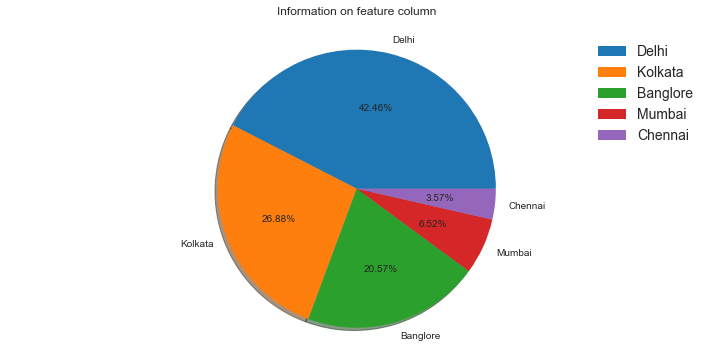

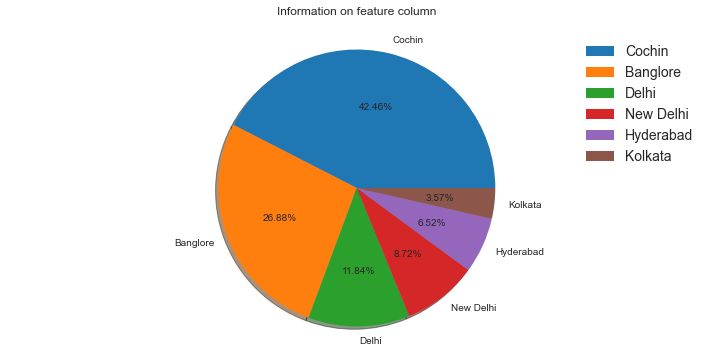

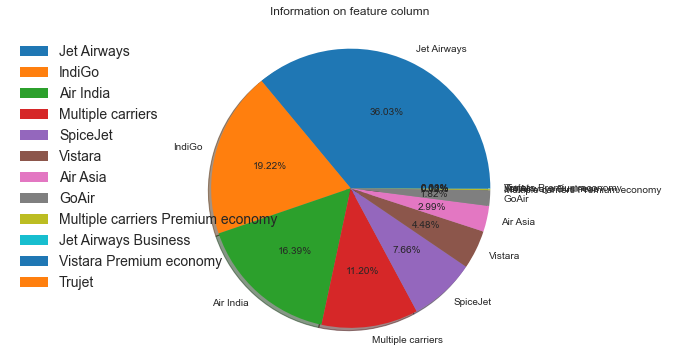

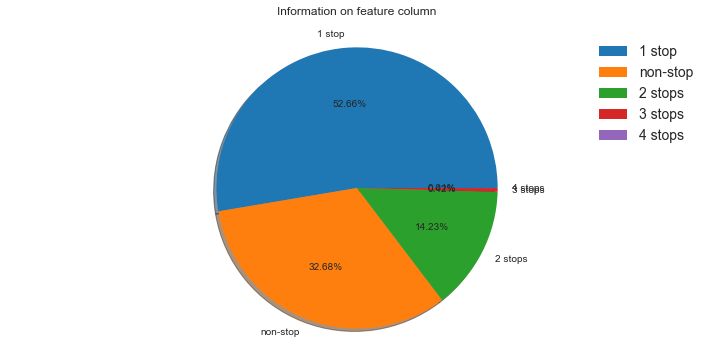

In [40]:
def generate_pie(x):
    plt.style.use('seaborn-white')
    plt.figure(figsize=(10,5))
    plt.pie(x.value_counts(), labels=x.value_counts().index, shadow=True, autopct='%1.2f%%')
    plt.legend(prop={'size':14})
    plt.axis('equal')
    plt.title('Information on feature column\n')
    plt.tight_layout()
    return plt.show()

generate_pie(train['Source'])
generate_pie(train['Destination'])
generate_pie(train['Airline'])
generate_pie(train['Total_Stops'])

I have created a function to generate pie plots for our feature columns. My observation for them are:

- 1 In the source column we have the highest number of rows covered by Delhi and the lowest number of rows covered by Chennai
- 2 In the destination column we have the highest number of rows covered by Cochin and the lowest number of rows covered by Kolkata
- 3 higest number of flights are run by jet airlines and lowest number of jets are run by trujet
- 4 maximum number flights are run with 1 stop and non stop and lowest are with 3 and 4 stops.


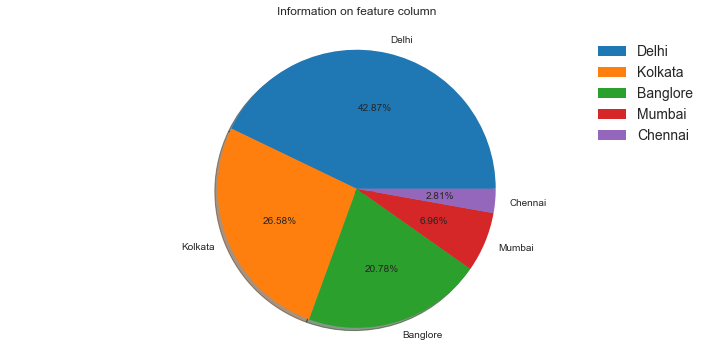

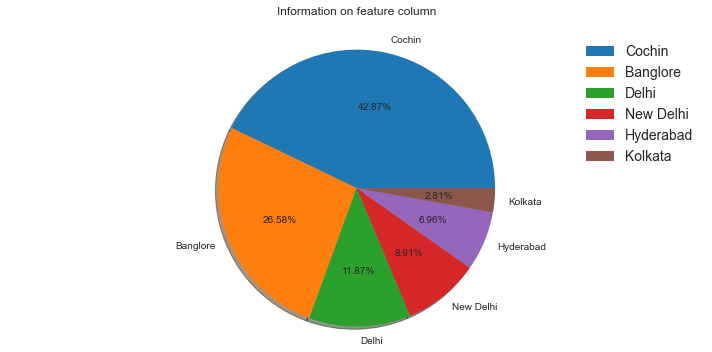

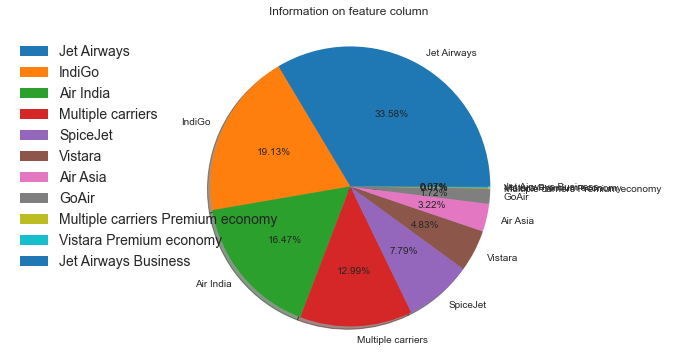

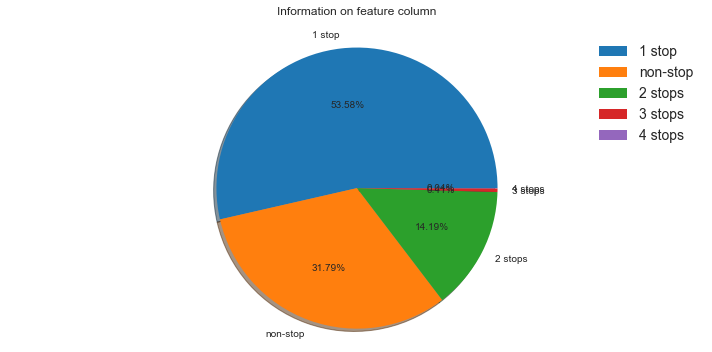

In [56]:
def generate_pie(x):
    plt.style.use('seaborn-white')
    plt.figure(figsize=(10,5))
    plt.pie(x.value_counts(), labels=x.value_counts().index, shadow=True, autopct='%1.2f%%')
    plt.legend(prop={'size':14})
    plt.axis('equal')
    plt.title('Information on feature column\n')
    plt.tight_layout()
    return plt.show()

generate_pie(test['Source'])
generate_pie(test['Destination'])
generate_pie(test['Airline'])
generate_pie(test['Total_Stops'])

Min Price  1759
Max Price  79512


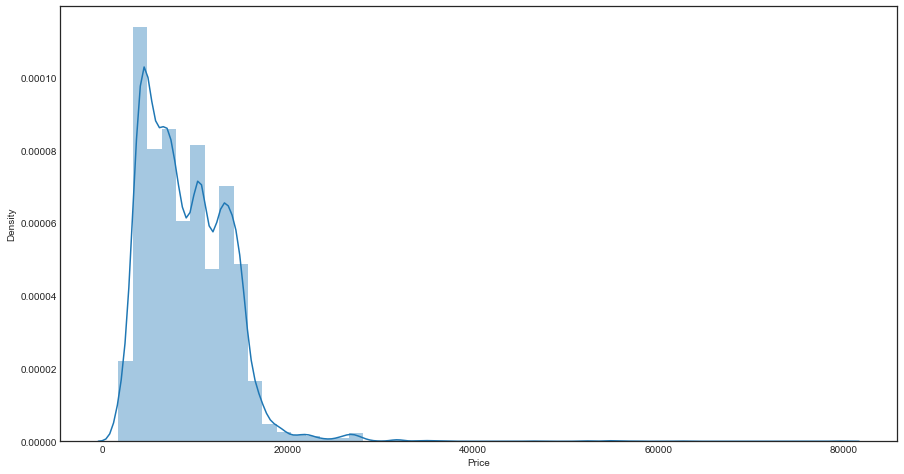

In [41]:
plt.figure(figsize=(15,8))
sns.distplot(train['Price']);
print('Min Price ',train['Price'].min())
print('Max Price ',train['Price'].max())

the price of a flight ticket is ranging from 1759 to 79512the data is right skewed

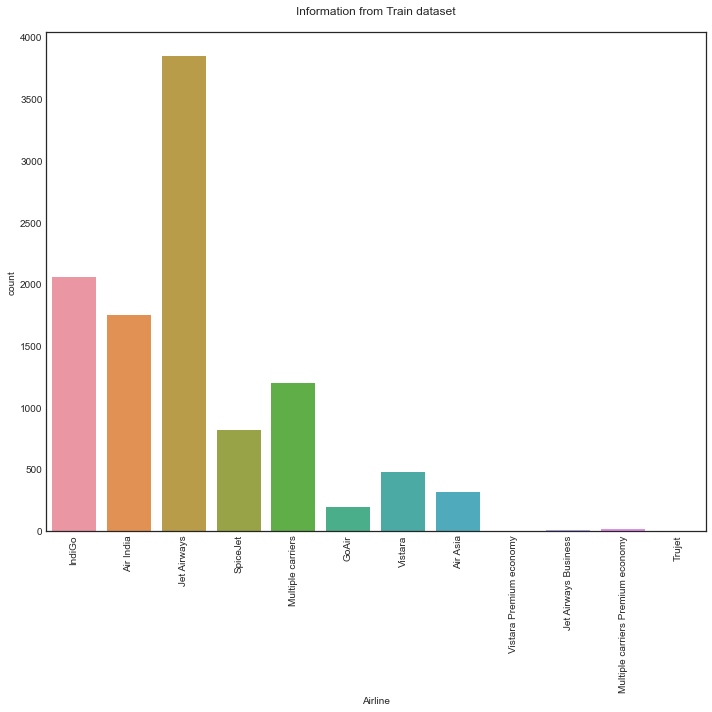

In [48]:
def generate_countplot(x):
    plt.figure(figsize=(10,10))
    sns.countplot(x)
    plt.xticks(rotation=90)
    plt.title('Information from Train dataset\n')
    plt.tight_layout()
    return plt.show()


generate_countplot(train['Airline'])
#generate_countplot(text['Airline'])

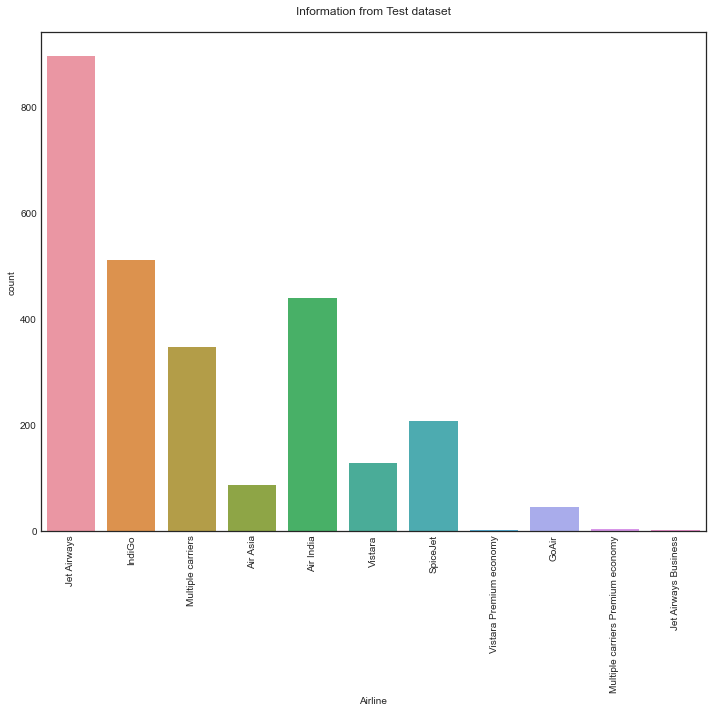

In [47]:
def generate_countplot(x):
    plt.figure(figsize=(10,10))
    sns.countplot(x)
    plt.xticks(rotation=90)
    plt.title('Information from Test dataset\n')
    plt.tight_layout()
    return plt.show()



generate_countplot(test['Airline'])

in both the graph highest can be seen in jet airlines and lowest in train dataset is trujet but in test data set we don't have any trujet.

In [49]:
train['Route'].value_counts()

DEL → BOM → COK          2376
BLR → DEL                1552
CCU → BOM → BLR           979
CCU → BLR                 724
BOM → HYD                 621
                         ... 
CCU → IXZ → MAA → BLR       1
CCU → IXA → BLR             1
BOM → CCU → HYD             1
BOM → GOI → HYD             1
BOM → JLR → HYD             1
Name: Route, Length: 128, dtype: int64

frequent route is DEL → BOM → COK, this route is been used 2376 times

In [50]:
test['Route'].value_counts()

DEL → BOM → COK                624
BLR → DEL                      389
CCU → BOM → BLR                253
CCU → BLR                      172
BOM → HYD                      164
                              ... 
BLR → VGA → VTZ → DEL            1
CCU → DEL → COK → TRV → BLR      1
BOM → IXC → DEL → HYD            1
CCU → IXR → BBI → BLR            1
BLR → BOM → IDR → DEL            1
Name: Route, Length: 100, dtype: int64

frequent route in this dataset is same as other one DEL → BOM → COK, but used a lil bit low with 624

In [51]:
train['Dep_Time'].value_counts()

18:55    233
17:00    227
07:05    205
10:00    203
07:10    202
        ... 
16:25      1
12:45      1
22:25      1
03:00      1
21:35      1
Name: Dep_Time, Length: 222, dtype: int64

preferd departure time is 18:55

In [52]:
test['Dep_Time'].value_counts()

10:00    62
18:55    55
20:00    53
14:05    51
17:00    48
         ..
13:30     1
15:35     1
22:30     1
06:15     1
06:25     1
Name: Dep_Time, Length: 199, dtype: int64

preferd departure time in this dataset is 10:00

In [53]:
train['Arrival_Time'].value_counts()

19:00           423
21:00           360
19:15           333
16:10           154
12:35           122
               ... 
02:45 19 Jun      1
23:00 16 May      1
14:35 13 Jun      1
00:25 07 Mar      1
00:50 19 May      1
Name: Arrival_Time, Length: 1343, dtype: int64

19:00 is a frequent arrival time

In [54]:
test['Arrival_Time'].value_counts()

19:00           113
21:00           106
19:15           101
12:35            37
16:10            31
               ... 
07:40 04 Jun      1
14:25 10 Jun      1
08:40             1
00:40 02 May      1
18:05 13 Mar      1
Name: Arrival_Time, Length: 704, dtype: int64

19:00 is frequent arrival time in this dataset

In [57]:
train['Duration'].value_counts()

2h 50m     550
1h 30m     386
2h 55m     337
2h 45m     337
2h 35m     329
          ... 
29h 30m      1
47h 40m      1
32h 55m      1
29h 40m      1
37h 10m      1
Name: Duration, Length: 368, dtype: int64

2h 50m is normal duration fopr most of the flights

In [58]:
test['Duration'].value_counts()

2h 50m     122
1h 30m     107
2h 45m      95
2h 55m      81
3h          72
          ... 
24h 15m      1
19h 45m      1
27h 55m      1
30h 25m      1
16h 30m      1
Name: Duration, Length: 320, dtype: int64

2h 50m is normal duration of time in flights for this dataset

No info                         8344
In-flight meal not included     1982
No check-in baggage included     320
1 Long layover                    19
Change airports                    7
Business class                     4
No Info                            3
Red-eye flight                     1
1 Short layover                    1
2 Long layover                     1
Name: Additional_Info, dtype: int64

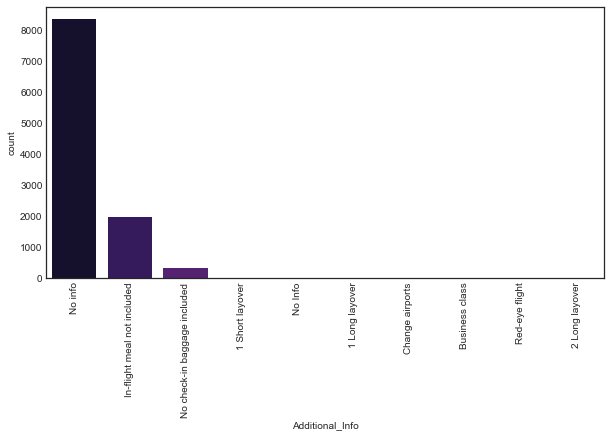

In [63]:
plt.figure(figsize=(10,5))
sns.countplot(train['Additional_Info'],palette='magma')
plt.xticks(rotation=90)
train['Additional_Info'].value_counts()

train dataset, Mostly flights have no additional information and the count is 8344. 2 Long layover is the least additional information and it counts 2

No info                         2148
In-flight meal not included      444
No check-in baggage included      76
Change airports                    1
1 Long layover                     1
Business class                     1
Name: Additional_Info, dtype: int64

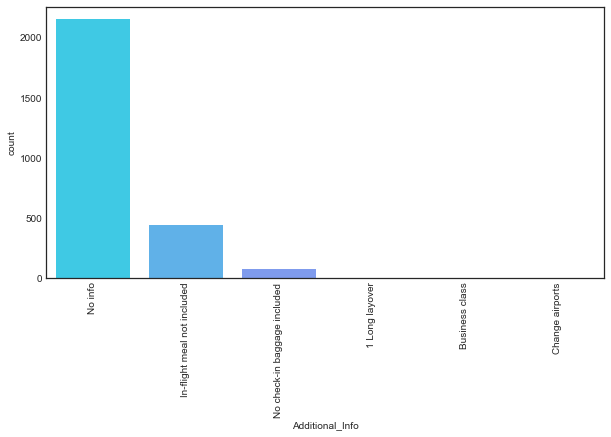

In [62]:
plt.figure(figsize=(10,5))
sns.countplot(test['Additional_Info'],palette='cool')
plt.xticks(rotation=90)
test['Additional_Info'].value_counts()

test dataset, Mostly flights have no additional information and the count is 2148. Change airports is the least additional information and it counts only 1.

- Bivariate

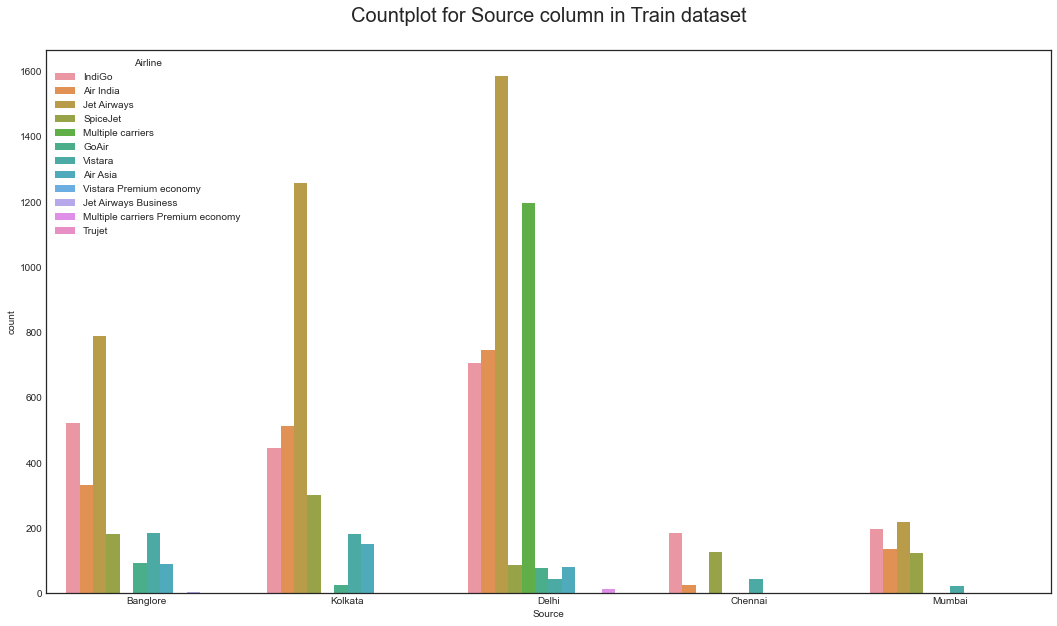

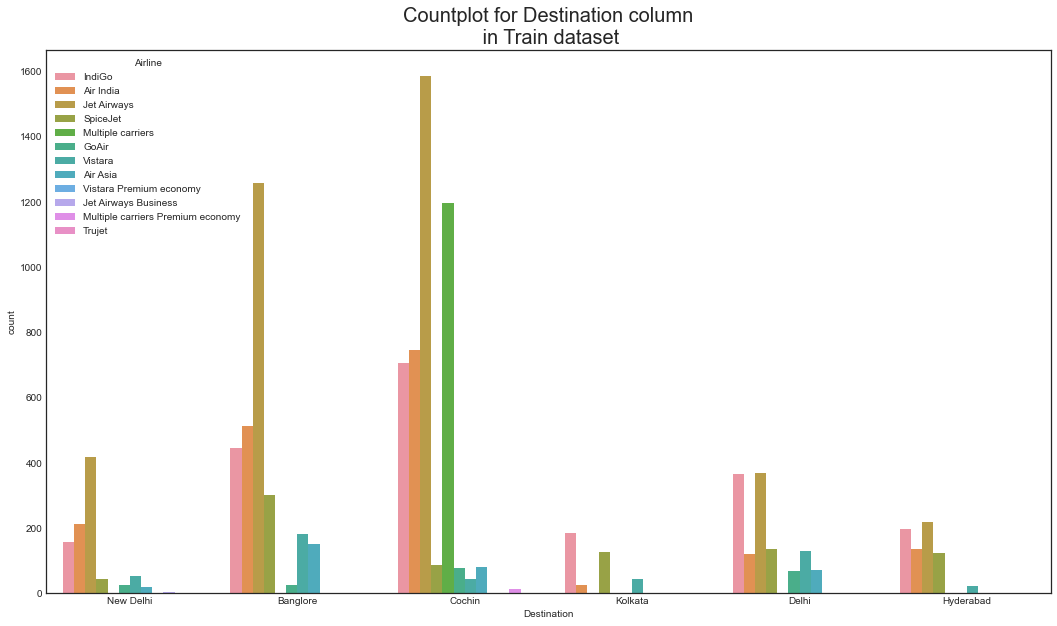

In [71]:
x = "Source"
plt.figure(figsize=(18,10))
sns.countplot(x = x, hue = "Airline", data = train)
plt.title(f"Countplot for {x} column in Train dataset\n", fontsize = 20)
plt.show()

x = "Destination"
plt.figure(figsize=(18,10))
sns.countplot(x = x, hue = "Airline", data = train)
plt.title(f"Countplot for {x} column\n in Train dataset", fontsize = 20)
plt.show()

we can clearly see the maximum number of flights are running for jet airlines and many are there we can't even compare because of thir low use

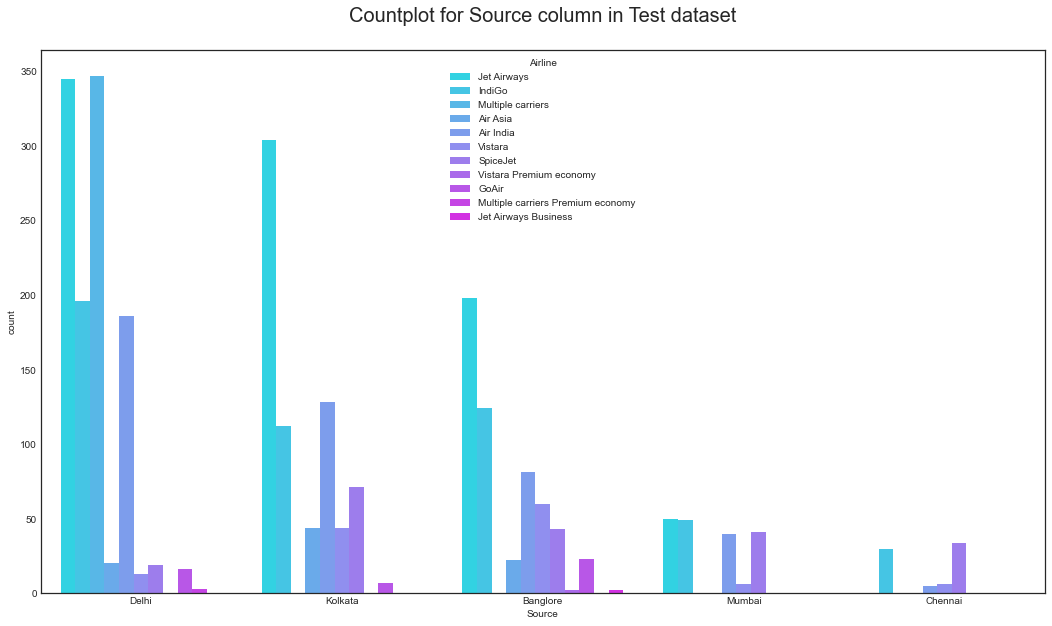

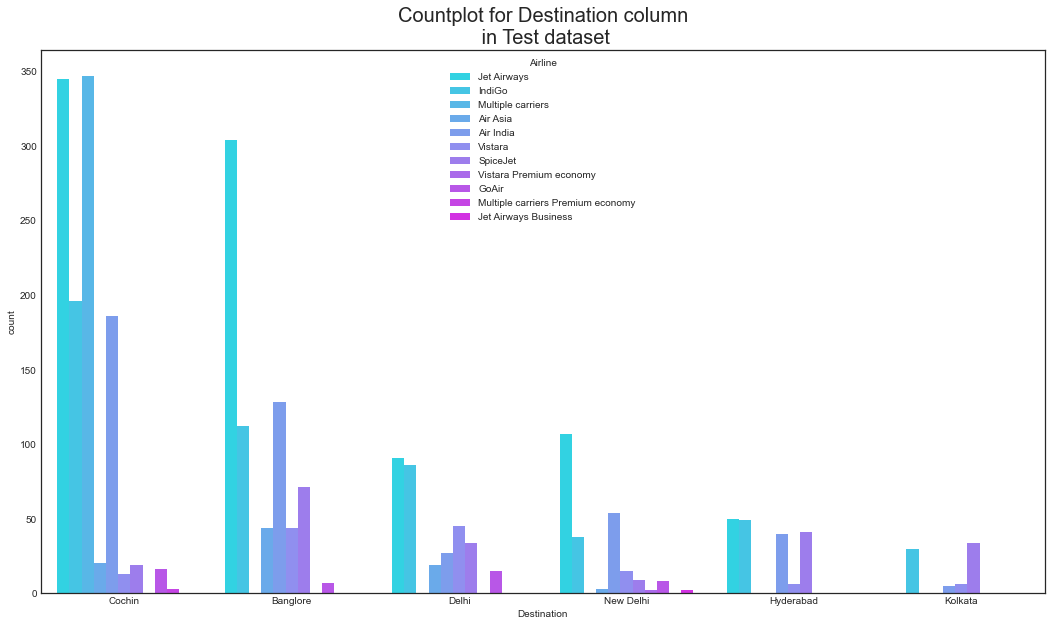

In [73]:
x = "Source"
plt.figure(figsize=(18,10))
sns.countplot(x = x, hue = "Airline", palette='cool',data = test)
plt.title(f"Countplot for {x} column in Test dataset\n", fontsize = 20)
plt.show()

x = "Destination"
plt.figure(figsize=(18,10))
sns.countplot(x = x, hue = "Airline", palette='cool', data = test)
plt.title(f"Countplot for {x} column\n in Test dataset", fontsize = 20)
plt.show()

maximum number of flights are running from delhi while the lowest are runing from chennai

and the maximum number of flights are going to cochin rather than kolkata as the lowest

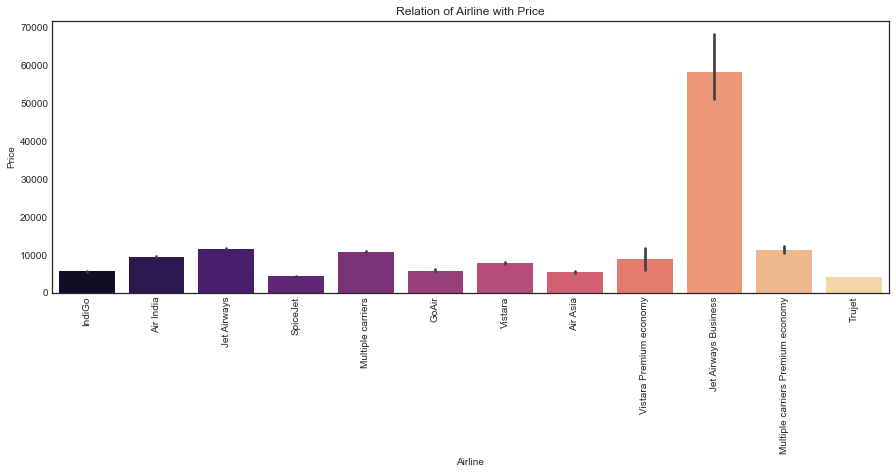

In [76]:
#Relation of Airline with Price
plt.figure(figsize=(15,5))
sns.barplot(x='Airline',y='Price',palette='magma',data=train).set_title('Relation of Airline with Price')
plt.xticks(rotation=90)
plt.show();

oviously a buiness class flights will run high on cash, so the jet airlways buiness planes are costly

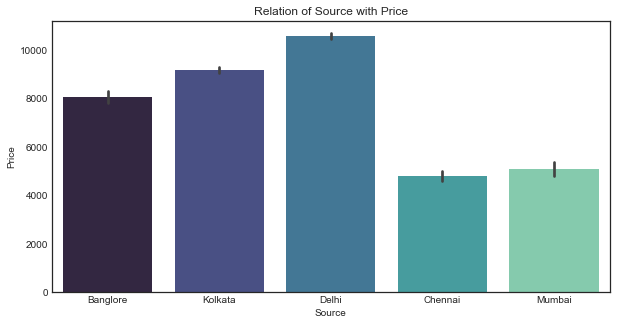

In [80]:
#Relation of Source with Price
plt.figure(figsize=(10,5))
sns.barplot(x='Source',y='Price',palette='mako',data=train).set_title('Relation of Source with Price')
plt.show();

flights from delhi is pricey, meanwhile flights takes off from delhi are more so it is related. 

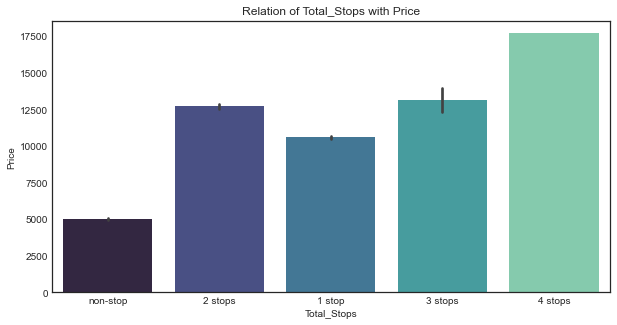

In [81]:
plt.figure(figsize=(10,5))
sns.barplot(x='Total_Stops',y='Price',palette='mako',data=train).set_title('Relation of Total_Stops with Price')
plt.show()

greater the stops greater it gets expensive

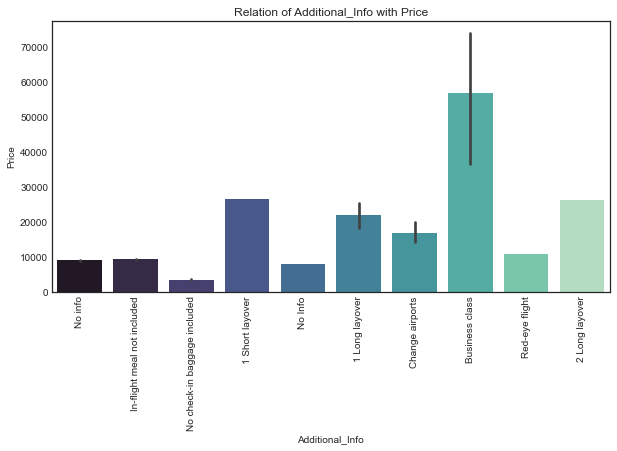

In [82]:
#Relation of Additional_Info with Price
plt.figure(figsize=(10,5))
sns.barplot(x='Additional_Info',y='Price',palette='mako',data=train).set_title('Relation of Additional_Info with Price')
plt.xticks(rotation=90)
plt.show();

Travelling by Business class is very expensive, And No check-in baggage included flights are cost effective.

# Data Engineering

- train dataset

In [83]:
# Creating 3 different columns for day, month and year data
train['year'] = pd.DatetimeIndex(train['Date_of_Journey']).year 
train['month'] = pd.DatetimeIndex(train['Date_of_Journey']).month 
train['day'] = pd.DatetimeIndex(train['Date_of_Journey']).day

In [84]:
# the train dataset is having 3 different column for day, month and year
train.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,year,month,day
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897,2019,3,24
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662,2019,1,5
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882,2019,9,6
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218,2019,12,5
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302,2019,1,3


In [127]:
#the Date_of_Journey column is not needed
train.drop(["Date_of_Journey"],axis = 1,inplace = True)

In [85]:
# Creating 2 different columns for hour and minutes data
train["Dep_hour"] = pd.to_datetime(train["Dep_Time"]).dt.hour
train["Dep_min"] = pd.to_datetime(train["Dep_Time"]).dt.minute
train.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,year,month,day,Dep_hour,Dep_min
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897,2019,3,24,22,20
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662,2019,1,5,5,50
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882,2019,9,6,9,25
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218,2019,12,5,18,5
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302,2019,1,3,16,50


In [86]:
# Dropping the Dep_Time data as it's not needed
train.drop(["Dep_Time"],axis =1,inplace = True)

In [87]:
# Creating 2 different columns for hour and minutes from Arrival_Time data
train["Arrival_hour"]=pd.to_datetime(train.Arrival_Time).dt.hour
train["Arrival_min"] = pd.to_datetime(train.Arrival_Time).dt.minute
train.head()

,Airline,Date_of_Journey,Source,Destination,Route,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,year,month,day,Dep_hour,Dep_min,Arrival_hour,Arrival_min
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,01:10 22 Mar,2h 50m,non-stop,No info,3897,2019,3,24,22,20,1,10
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,13:15,7h 25m,2 stops,No info,7662,2019,1,5,5,50,13,15
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,04:25 10 Jun,19h,2 stops,No info,13882,2019,9,6,9,25,4,25
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,23:30,5h 25m,1 stop,No info,6218,2019,12,5,18,5,23,30
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,21:35,4h 45m,1 stop,No info,13302,2019,1,3,16,50,21,35


In [88]:
# Dropping the Arival_Time data as it's already separated into hours and minutes in two different columns
train.drop(["Arrival_Time"],axis = 1,inplace=True)

In [89]:
#Conversion of duration
duration = list(train["Duration"])# Assigning Duration column into list

for i in range(len(duration)):
    if len(duration[i].split()) != 2:    # Checking if duration contains only hour or mins
        if "h" in duration[i]:           # if there 'h' present
            duration[i] = duration[i].strip() + " 0m"   # then Add 0 as minute
        else:
            duration[i] = "0h " + duration[i]           # Add 0 as hour

duration_hours = []  # the new duration_hours column after conversion
duration_mins = []   # the new duration_minutes column after conversion   
for i in range(len(duration)):
    duration_hours.append(int(duration[i].split(sep = "h")[0]))    # Extracting hours from duration
    duration_mins.append(int(duration[i].split(sep = "m")[0].split()[-1]))   # Extracting  minutes from duration

In [90]:
#Adding the duration columns in the train dataset
train["Duration_hours"] = duration_hours
train["Duration_mins"] = duration_mins

In [91]:
#  As the Extraction is done, now we can drop the old Duration column
train.drop(["Duration"],axis=1,inplace=True)
train.head()

,Airline,Date_of_Journey,Source,Destination,Route,Total_Stops,Additional_Info,Price,year,month,day,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,non-stop,No info,3897,2019,3,24,22,20,1,10,2,50
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info,7662,2019,1,5,5,50,13,15,7,25
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,No info,13882,2019,9,6,9,25,4,25,19,0
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,1 stop,No info,6218,2019,12,5,18,5,23,30,5,25
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,1 stop,No info,13302,2019,1,3,16,50,21,35,4,45


day, month and year columns are made out of Date_of_journey, Dep_hour and Dep_min columns are made out of Dep_Time, Arrival_hour and Arrival_min columns are made out of Arrival_time and Duration_hours and Duration_mins are made out of Duration column of the train data. All the newly assign columns are looking more simple than before.

- test dataset

In [93]:
#conversion of dates of journey
# Creating 3 different columns for day, month and year data
test['year'] = pd.DatetimeIndex(test['Date_of_Journey']).year 
test['month'] = pd.DatetimeIndex(test['Date_of_Journey']).month 
test['day'] = pd.DatetimeIndex(test['Date_of_Journey']).day

In [94]:
# Now the Date_of_Journey column is not needed
test.drop(["Date_of_Journey"],axis = 1,inplace = True)
#the test dataset is having 3 different columns for day, month and year
test.head()

,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,year,month,day
0,Jet Airways,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info,2019,6,6
1,IndiGo,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info,2019,12,5
2,Jet Airways,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included,2019,5,21
3,Multiple carriers,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1 stop,No info,2019,5,21
4,Air Asia,Banglore,Delhi,BLR → DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info,2019,6,24


In [95]:
#We are using same date time module to make the Dep_time column more simple and useful for the model.

# Creating 2 different columns for hour and minutes data
test["Dep_hour"] = pd.to_datetime(test["Dep_Time"]).dt.hour
test["Dep_min"] = pd.to_datetime(test["Dep_Time"]).dt.minute

In [96]:
# Dropping the Dep_Time data as it's not needed
test.drop(["Dep_Time"],axis = 1,inplace = True)

#the test dataset is having 2 more different columns Dep_hour and Dep_min
test.head()

,Airline,Source,Destination,Route,Arrival_Time,Duration,Total_Stops,Additional_Info,year,month,day,Dep_hour,Dep_min
0,Jet Airways,Delhi,Cochin,DEL → BOM → COK,04:25 07 Jun,10h 55m,1 stop,No info,2019,6,6,17,30
1,IndiGo,Kolkata,Banglore,CCU → MAA → BLR,10:20,4h,1 stop,No info,2019,12,5,6,20
2,Jet Airways,Delhi,Cochin,DEL → BOM → COK,19:00 22 May,23h 45m,1 stop,In-flight meal not included,2019,5,21,19,15
3,Multiple carriers,Delhi,Cochin,DEL → BOM → COK,21:00,13h,1 stop,No info,2019,5,21,8,0
4,Air Asia,Banglore,Delhi,BLR → DEL,02:45 25 Jun,2h 50m,non-stop,No info,2019,6,24,23,55


In [97]:
#Conversion of Arrival_Time
# Creating 2 different columns for hour and minutes from Arrival_Time data
test["Arrival_hour"]=pd.to_datetime(test.Arrival_Time).dt.hour
test["Arrival_min"] = pd.to_datetime(test.Arrival_Time).dt.minute

# Dropping the Arival_Time data as it's already separated into hours and minutes in two different columns
test.drop(["Arrival_Time"],axis = 1,inplace = True)

#the test dataset is having 2 more different columns Arrival_hour ,Arrival_min
test.head()

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,year,month,day,Dep_hour,Dep_min,Arrival_hour,Arrival_min
0,Jet Airways,Delhi,Cochin,DEL → BOM → COK,10h 55m,1 stop,No info,2019,6,6,17,30,4,25
1,IndiGo,Kolkata,Banglore,CCU → MAA → BLR,4h,1 stop,No info,2019,12,5,6,20,10,20
2,Jet Airways,Delhi,Cochin,DEL → BOM → COK,23h 45m,1 stop,In-flight meal not included,2019,5,21,19,15,19,0
3,Multiple carriers,Delhi,Cochin,DEL → BOM → COK,13h,1 stop,No info,2019,5,21,8,0,21,0
4,Air Asia,Banglore,Delhi,BLR → DEL,2h 50m,non-stop,No info,2019,6,24,23,55,2,45


In [98]:
#Conversion of duration
duration = list(test["Duration"])# Assigning Duration column into list

for i in range(len(duration)):
    if len(duration[i].split()) != 2:    # Checking if duration contains only hour or mins
        if "h" in duration[i]:           # if there 'h' present
            duration[i] = duration[i].strip() + " 0m"   # then Add 0 as minute
        else:
            duration[i] = "0h " + duration[i]           # Add 0 as hour

duration_hours = []  # the new duration_hours column after conversion
duration_mins = []   # the new duration_minutes column after conversion   
for i in range(len(duration)):
    duration_hours.append(int(duration[i].split(sep = "h")[0]))    # Extracting hours from duration
    duration_mins.append(int(duration[i].split(sep = "m")[0].split()[-1]))   # Extracting  minutes from duration

In [99]:
# Adding the duration columns in the train dataset
test["Duration_hours"] = duration_hours
test["Duration_mins"] = duration_mins

In [100]:
# As the Extraction is done, now we can drop the old Duration column
test.drop(["Duration"],axis=1,inplace=True)
test.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,year,month,day,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins
0,Jet Airways,Delhi,Cochin,DEL → BOM → COK,1 stop,No info,2019,6,6,17,30,4,25,10,55
1,IndiGo,Kolkata,Banglore,CCU → MAA → BLR,1 stop,No info,2019,12,5,6,20,10,20,4,0
2,Jet Airways,Delhi,Cochin,DEL → BOM → COK,1 stop,In-flight meal not included,2019,5,21,19,15,19,0,23,45
3,Multiple carriers,Delhi,Cochin,DEL → BOM → COK,1 stop,No info,2019,5,21,8,0,21,0,13,0
4,Air Asia,Banglore,Delhi,BLR → DEL,non-stop,No info,2019,6,24,23,55,2,45,2,50


day, month and year columns are made out of Date_of_journey, Dep_hour and Dep_min columns are made out of Dep_Time, Arrival_hour and Arrival_min columns are made out of Arrival_time and Duration_hours and Duration_mins are made out of Duration column of the test data. All the newly assign columns are looking more simple than before.

# Pre-Processing Pipeline

We are using get.dummies to encode the nominal data.

encoding the train dataset

In [102]:
#encode the nominal column Airline
Airline = train[["Airline"]]
Airline = pd.get_dummies(Airline,drop_first= True)
Airline.head()

,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy
0,0,0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0


In [103]:
#encode the column Source
Source = train[["Source"]]
Source = pd.get_dummies(Source,drop_first= True)
Source.head()

,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai
0,0,0,0,0
1,0,0,1,0
2,0,1,0,0
3,0,0,1,0
4,0,0,0,0


In [104]:
#encode the column Destination
Destination = train[["Destination"]]
Destination = pd.get_dummies(Destination, drop_first = True)
Destination.head()

,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0,0,0,0,1
1,0,0,0,0,0
2,1,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,1


In [105]:
#encode the column total_stops into serial number
train.replace({"non-stop": 0, "1 stop": 1, "2 stops": 2, "3 stops": 3, "4 stops": 4}, inplace = True)
train.head()

,Airline,Date_of_Journey,Source,Destination,Route,Total_Stops,Additional_Info,Price,year,month,day,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,0,No info,3897,2019,3,24,22,20,1,10,2,50
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,2,No info,7662,2019,1,5,5,50,13,15,7,25
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,2,No info,13882,2019,9,6,9,25,4,25,19,0
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,1,No info,6218,2019,12,5,18,5,23,30,5,25
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,1,No info,13302,2019,1,3,16,50,21,35,4,45


In [106]:
#dropping Route and Additional_info columns
train.drop(["Route", "Additional_Info"],axis = 1,inplace = True)

In [107]:
#concat those prior encoded columns into train dataset
train=pd.concat([train, Airline, Source, Destination], axis = 1)

In [108]:
# dropping those old not encoded columns
train.drop(["Airline", "Source", "Destination"], axis = 1, inplace = True)

In [109]:
train.head()

,Date_of_Journey,Total_Stops,Price,year,month,day,Dep_hour,Dep_min,Arrival_hour,Arrival_min,...,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,24/03/2019,0,3897,2019,3,24,22,20,1,10,...,0,0,0,0,0,0,0,0,0,1
1,1/05/2019,2,7662,2019,1,5,5,50,13,15,...,0,0,0,1,0,0,0,0,0,0
2,9/06/2019,2,13882,2019,9,6,9,25,4,25,...,0,0,1,0,0,1,0,0,0,0
3,12/05/2019,1,6218,2019,12,5,18,5,23,30,...,0,0,0,1,0,0,0,0,0,0
4,01/03/2019,1,13302,2019,1,3,16,50,21,35,...,0,0,0,0,0,0,0,0,0,1


encoding the test dataset

In [111]:
Airline = test[["Airline"]]
Airline = pd.get_dummies(Airline,drop_first= True)
Airline.head()

,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Vistara,Airline_Vistara Premium economy
0,0,0,0,1,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0


In [112]:
Source = test[["Source"]]
Source = pd.get_dummies(Source,drop_first= True)
Source.head()

,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai
0,0,1,0,0
1,0,0,1,0
2,0,1,0,0
3,0,1,0,0
4,0,0,0,0


In [113]:
Destination = test[["Destination"]]
Destination = pd.get_dummies(Destination, drop_first = True)
Destination.head()

,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,1,0,0,0,0
1,0,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,0,1,0,0,0


In [114]:
test.replace({"non-stop": 0, "1 stop": 1, "2 stops": 2, "3 stops": 3, "4 stops": 4}, inplace = True)


# dropping those not useful columns
test.drop(["Route", "Additional_Info"],axis = 1,inplace = True)
test.head()

,Airline,Source,Destination,Total_Stops,year,month,day,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins
0,Jet Airways,Delhi,Cochin,1,2019,6,6,17,30,4,25,10,55
1,IndiGo,Kolkata,Banglore,1,2019,12,5,6,20,10,20,4,0
2,Jet Airways,Delhi,Cochin,1,2019,5,21,19,15,19,0,23,45
3,Multiple carriers,Delhi,Cochin,1,2019,5,21,8,0,21,0,13,0
4,Air Asia,Banglore,Delhi,0,2019,6,24,23,55,2,45,2,50


In [115]:
#concat those prior encoded columns into test dataset
test=pd.concat([test, Airline, Source, Destination], axis = 1)
test.head()

,Airline,Source,Destination,Total_Stops,year,month,day,Dep_hour,Dep_min,Arrival_hour,...,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,Jet Airways,Delhi,Cochin,1,2019,6,6,17,30,4,...,0,0,1,0,0,1,0,0,0,0
1,IndiGo,Kolkata,Banglore,1,2019,12,5,6,20,10,...,0,0,0,1,0,0,0,0,0,0
2,Jet Airways,Delhi,Cochin,1,2019,5,21,19,15,19,...,0,0,1,0,0,1,0,0,0,0
3,Multiple carriers,Delhi,Cochin,1,2019,5,21,8,0,21,...,0,0,1,0,0,1,0,0,0,0
4,Air Asia,Banglore,Delhi,0,2019,6,24,23,55,2,...,0,0,0,0,0,0,1,0,0,0


In [116]:
# dropping those old not encoded columns
test.drop(["Airline", "Source", "Destination"],axis = 1, inplace = True)
test.head()

,Total_Stops,year,month,day,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,...,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,1,2019,6,6,17,30,4,25,10,55,...,0,0,1,0,0,1,0,0,0,0
1,1,2019,12,5,6,20,10,20,4,0,...,0,0,0,1,0,0,0,0,0,0
2,1,2019,5,21,19,15,19,0,23,45,...,0,0,1,0,0,1,0,0,0,0
3,1,2019,5,21,8,0,21,0,13,0,...,0,0,1,0,0,1,0,0,0,0
4,0,2019,6,24,23,55,2,45,2,50,...,0,0,0,0,0,0,1,0,0,0


In [117]:
# There is a single data in year column let's drop it:
train.drop('year',axis=1,inplace=True)

# There is a single data in year column let's drop it:
test.drop('year',axis=1,inplace=True)

**/

We have simplified the complex columns.

Encoded the nominal columns by using get.dummies.

Dropped unnnecessory columns.

                                                  /**

heatmap and cheacking the corelinearity

In [118]:
corr =train.corr()
corr.shape

(30, 30)

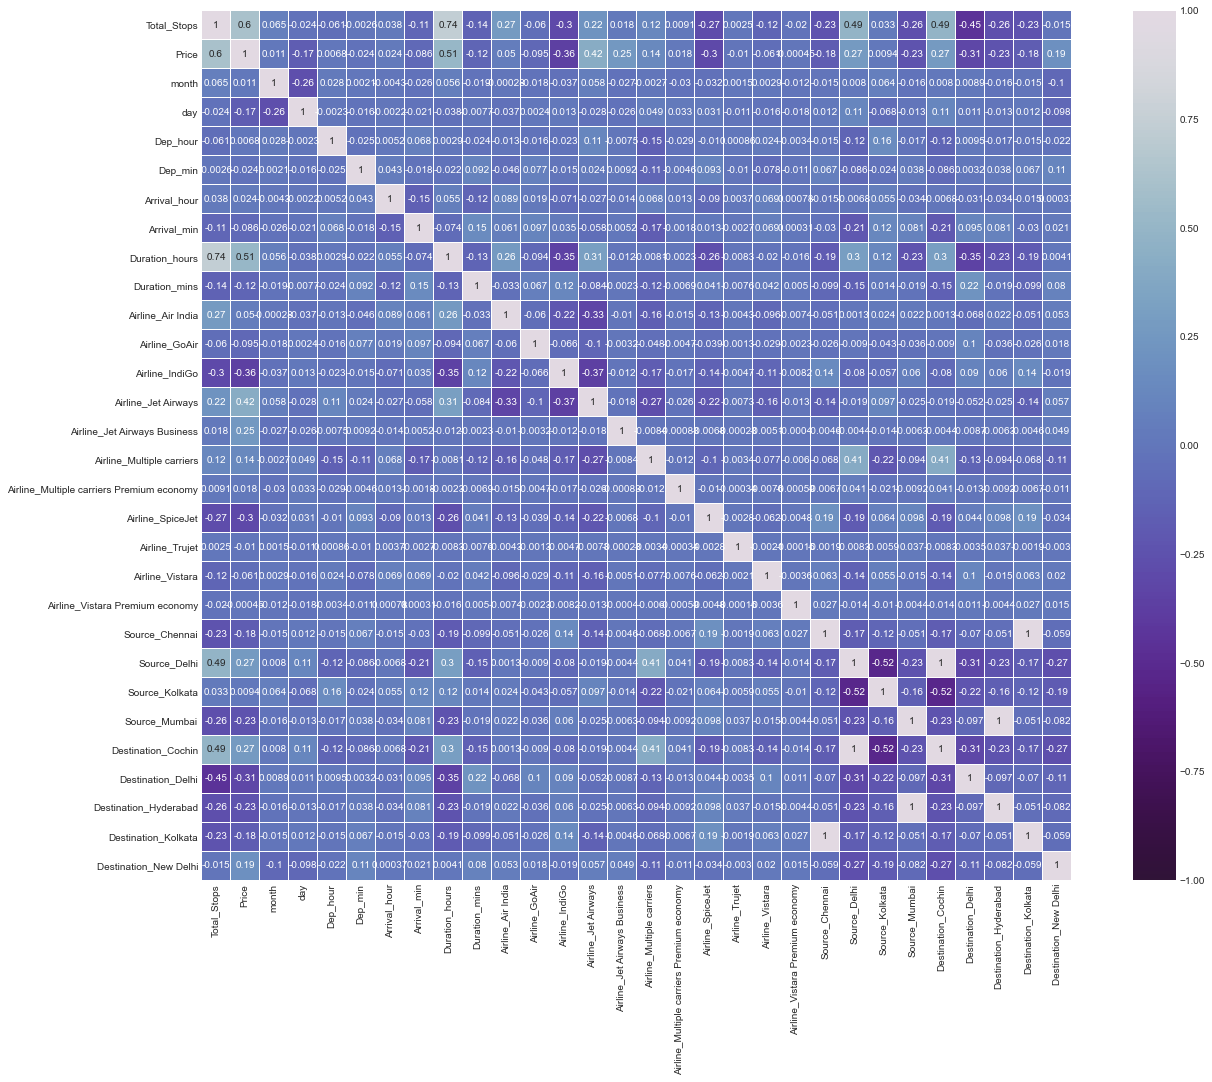

In [119]:
#Checking correlation matrix(heatmap) to understand the feature vs feature relationship.

plt.figure(figsize=(22,16))
sns.heatmap(corr,cbar=True,cmap='twilight_shifted',vmin=-1,vmax=1,square=True,fmt='.2g',annot=True,
            center=True,annot_kws={'size':10},linewidths=.1,linecolor='white')
plt.show();

In [120]:
# Dropping the correlated column from train dataset:
train.drop(["Destination_Cochin"],axis=1,inplace=True)

FEATURE SELECTION

We will use SelectKBest feature selection to select the best features that have more influence on the label. Here in this dataset we are using Anova test by using f_classif. f_classif do some Anova test with the features and come up with the scores for every feature. Then comparing each feature score, most important top features are got selected by SelectKBest.

In [128]:
train

,Total_Stops,Price,month,day,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,...,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0,3897,3,24,22,20,1,10,2,50,...,0,0,0,0,0,0,0,0,0,1
1,2,7662,1,5,5,50,13,15,7,25,...,0,0,0,0,1,0,0,0,0,0
2,2,13882,9,6,9,25,4,25,19,0,...,0,0,0,1,0,0,0,0,0,0
3,1,6218,12,5,18,5,23,30,5,25,...,0,0,0,0,1,0,0,0,0,0
4,1,13302,1,3,16,50,21,35,4,45,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,0,4107,9,4,19,55,22,25,2,30,...,0,0,0,0,1,0,0,0,0,0
10679,0,4145,4,27,20,45,23,20,2,35,...,0,0,0,0,1,0,0,0,0,0
10680,0,7229,4,27,8,20,11,20,3,0,...,0,0,0,0,0,0,1,0,0,0
10681,0,12648,1,3,11,30,14,10,2,40,...,1,0,0,0,0,0,0,0,0,1


In [129]:
#drop the label from feature
x=train.drop('Price',axis=1)
y=train.Price

In [130]:
#now feature selection
best_features=SelectKBest(score_func=f_classif,k=20)
fit=best_features.fit(x,y)
df_score=pd.DataFrame(fit.scores_)  #.score_ will score the best 17 features in decending order
df_columns=pd.DataFrame(x.columns)

In [131]:
#concatinate the features with scores
feature_scores=pd.concat([df_columns,df_score],axis=1)
feature_scores.columns=['Feature_name','score']  #output column name
print(feature_scores.nlargest(25,'score'))

                                 Feature_name       score
13               Airline_Jet Airways Business         inf
15  Airline_Multiple carriers Premium economy         inf
17                             Airline_Trujet         inf
19            Airline_Vistara Premium economy         inf
18                            Airline_Vistara  346.062470
12                        Airline_Jet Airways  338.230569
21                               Source_Delhi  228.959956
23                              Source_Mumbai  224.438108
25                      Destination_Hyderabad  224.438108
14                  Airline_Multiple carriers  220.660520
0                                 Total_Stops  212.974577
20                             Source_Chennai  212.072625
26                        Destination_Kolkata  212.072625
22                             Source_Kolkata  201.903356
9                           Airline_Air India  157.323048
24                          Destination_Delhi   98.167350
27            

STANDARDIZATION

In [132]:
scaler=StandardScaler()
x_scaled=scaler.fit_transform(x)

# Building Machine Learning Models.

In [140]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.25,random_state=42)

In [141]:
def maxr2_score(clf,X,Y):
    maxr2_score1=0
    for i in range(42,100):
        x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.20,random_state=i)
        clf.fit(x_train,y_train)
        pred=clf.predict(x_test)
        r2_cscore=r2_score(y_test,pred)
        if r2_cscore>maxr2_score1:
            maxr2_score1=r2_cscore
            final_r=i
    print('max r2 score corresponding to',final_r,'is',maxr2_score1*100)
    print('\n')
    print('cross validation score',cross_val_score(clf,x,y,scoring='r2').mean()*100)
    print('\n')
    print('Standard Deviation',cross_val_score(clf,x,y,scoring='r2').std()*100)
    print('\n')
    print('Training accuracy',clf.score(x_train,y_train)*100)
    print('\n')
    print('Test Accuracy',clf.score(x_test,y_test)*100)
    print('\n')
    print('MAE',mean_absolute_error(y_test,pred))
    print('\n')
    print('MSE',mean_squared_error(y_test,pred))
    print('\n')
    print('RMSE',np.sqrt(mean_squared_error(y_test,pred)))
    print('\n')
    sns.regplot(pred,y_test)
    return final_r

max r2 score corresponding to 76 is 61.860279200752984


cross validation score 57.3378769753068


Standard Deviation 2.2808275976485004


Training accuracy 71.97113252531705


Test Accuracy 61.26808422373764


MAE 1851.2254562470753


MSE 7549761.516817969


RMSE 2747.6829360058937




76

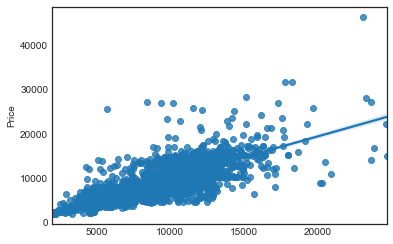

In [142]:
#KNN Regresso
knn = KNeighborsRegressor()
maxr2_score(knn,x,y)

max r2 score corresponding to 58 is 83.64110159508263


cross validation score 80.26052679735581


Standard Deviation 3.9025468597309216


Training accuracy 95.42631382762508


Test Accuracy 79.66753444230189


MAE 1219.7369672579798


MSE 3963275.83939483


RMSE 1990.7977896800141




58

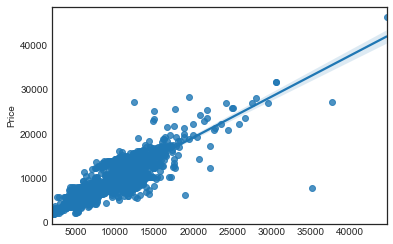

In [143]:
#Random Forest
rf = RandomForestRegressor()
maxr2_score(rf,x,y)

max r2 score corresponding to 79 is 81.11993475327475


cross validation score 77.50931007474769


Standard Deviation 1.6291207790317965


Training accuracy 79.44198438235168


Test Accuracy 77.66679564518451


MAE 1505.632125415572


MSE 4353266.896458394


RMSE 2086.4483929535363




79

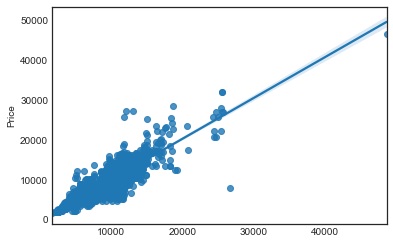

In [144]:
#Gradient Boosting Regressor
gbr = GradientBoostingRegressor()
maxr2_score(gbr,x,y)

max r2 score corresponding to 94 is 77.95606880804394


cross validation score 70.17919422237509


Standard Deviation 6.208275427551492


Training accuracy 97.20625164365646


Test Accuracy 63.734637298689044


MAE 1439.3446186242395


MSE 7068972.299160167


RMSE 2658.753899698159




94

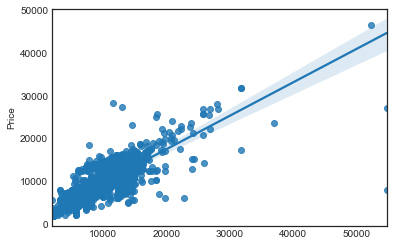

In [145]:
#ecision Tree Regressor
dt = DecisionTreeRegressor()
maxr2_score(dt,x,y)

max r2 score corresponding to 44 is 86.92051984629092


cross validation score 83.34732855790641


Standard Deviation 2.23650620619599


Training accuracy 93.62460913173382


Test Accuracy 82.16323461513895


MAE 1213.2549097742162


MSE 3476805.1667009466


RMSE 1864.6193087869026




44

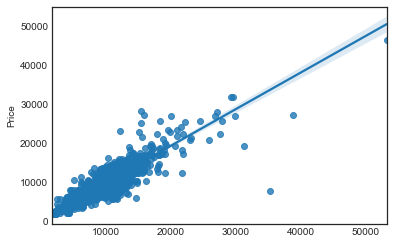

In [146]:
#XGBRegressor
xgb=xgb.XGBRegressor()
maxr2_score(xgb,x,y)

XGBRegressor got best accuracy of 87%, hence, we are going to tune it's parameter to obtain best result.

In [151]:
## Importing machine learning Library
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import  GradientBoostingRegressor
from sklearn.linear_model import Ridge,Lasso,RidgeCV,LassoCV
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score,accuracy_score
from sklearn.model_selection import cross_val_score,GridSearchCV,train_test_split

In [152]:
xgbr = xgb.XGBRegressor()
grid_param= {'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7, 10],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 500],
        'objective':['reg:squarederror']}
gbr_search=GridSearchCV(xgbr,param_grid=grid_param,scoring='neg_mean_squared_error',n_jobs=1,cv=5)
gbr_search.fit(x_train,y_train)
gbr_search.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [153]:
xgbr= xgb.XGBRegressor(learning_rate=0.01,max_depth=10,colsample_bytree=0.7,n_estimators=500) 
xgbr.fit(x_train,y_train)
y_pred=xgbr.predict(x_test)

In [154]:
print("*** Accuracy Post Tuning***")
print(metrics.r2_score(y_test,y_pred)*100)

*** Accuracy Post Tuning***
84.82752746163284


# Prediction of Flight Prices

In [155]:
X_test=test  # reinstantiating test column into a variable 

In [156]:
# Doing the prediction using the test dataset
xgbr.fit(x_train, y_train)
xgbr_pred = xgbr.predict(X_test)
score=xgbr.score(x_train,y_train)
print(score,xgbr,':')

0.9342179668284317 XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None) :


In [157]:
#model(test dataset) prediction using gbr
x_predict = list(xgbr.predict(X_test))
df_new = {'predicted_values':x_predict[0:1000],'orignal_values':y_test[0:1000]}
print(pd.DataFrame(df_new))

      predicted_values  orignal_values
6075      13551.704102           16655
3544       5249.481445            4959
9291      14198.861328            9187
5032      10571.091797            3858
2483       4046.589355           12898
...                ...             ...
590        4461.775391            8586
5613       6861.494141           13469
3958       8416.470703            5298
5245       5382.348145           15107
8458       9662.501953           10262

[1000 rows x 2 columns]


# saving the model

In [159]:
import joblib
joblib.dump(xgbr,'flight_price_pred.pkl')

['flight_price_pred.pkl']

# testing the saved model

In [160]:
loaded_model=joblib.load('flight_price_pred.pkl')
prediction=loaded_model.predict(X_test)

In [161]:
prediction

array([13551.704 ,  5249.4814, 14198.861 , ..., 18080.31  , 12663.281 ,
        7830.605 ], dtype=float32)

Inference:

In this project we have scraped the flight data from airline webpages. Then the comma separated value file is loaded into a data frame. Luckily we don't have any missing values in our data set. Looking at the data set we understand that there are some features needs to be processed like converting the data types and get the actual value from the string entries from the time related columns. After the data is been processed I have done some EDA to understand the relation among features and the target variable. Features like flight duration, number of stops during the journey and the availability of meals are playing major role in predicting the prices of the flights